In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

Train_Transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), # 50% chance to rorate
                                      transforms.RandomRotation(10),  # rotation agnle（-10，10）
                                      transforms.Grayscale(num_output_channels=1),  # makesure covert to grayscale 
                                      transforms.ToTensor(),# transfer to Tensor
                                      transforms.Normalize(0.5, 0.5)]) # mean and std
 
Test_Transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5)])

In [2]:
# Load Dataset
train_path = '/Users/john/Desktop/ML/Fer2013/train'  # dataset path for training
test_path = '/Users/john/Desktop/ML/Fer2013/test'# dateset path for testing

Train_Data = ImageFolder(train_path, transform = Train_Transforms)
Test_Data = ImageFolder(test_path, transform = Test_Transforms)
 
Train_Loader = DataLoader(Train_Data, batch_size = 64, shuffle = True, pin_memory=True)  # used for training
Test_Loader = DataLoader(Test_Data, batch_size = 64, shuffle = True, pin_memory=True) # used for testing


In [3]:
# Feature Extraction
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)    #input =in_channels,output =16
 
        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)   #output channel =16 as next input
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2) #input =16, output =24, kernel_size 5*5
 
        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1) 
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)
 
        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)
 
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
 
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
 
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
 
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
 
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, dim=1)  # concatenate tensors along a  dimension =1
    
    
# Biuld a model : Cov，inception，pooling，activation，
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Con1 = torch.nn.Conv2d(1, 10, kernel_size=5, stride=1)
        self.Con2 = torch.nn.Conv2d(88, 20, kernel_size=5, stride=1)
        self.Con3 = torch.nn.Conv2d(88, 10, kernel_size=5, stride=1)
        self.incep1 = InceptionA(in_channels=10)
        self.incep2 = InceptionA(in_channels=20)
        self.Pooling = torch.nn.MaxPool2d(2)
        self.Activate = torch.nn.ReLU()
        self.fc = torch.nn.Linear(250, 7)
 
    def forward(self, x):
        batch_size = x.size(0)
        x = self.Activate(self.Pooling(self.Con1(x)))
        x = self.incep1(x)
        x = self.Activate(self.Pooling(self.Con2(x)))
        x = self.incep2(x)
        x = self.Activate(self.Con3(x))  
        x = x.view(batch_size, -1)        
        return self.fc(x)
 

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu') #  CUDA or CPU
model = Model().to(device)    # my CPU here
criterion = torch.nn.CrossEntropyLoss() #Get entropyLoss
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# Learning Rate Decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # LR will deacy 0.1*LR after each 10 epochs 

import numpy as np
import matplotlib.pyplot as plt

epoch_times = 20
epoch =0
epoch_arange = np.arange(1, epoch_times + 1, 1) # start stop step
loss_result = np.zeros(epoch_times)
accuracy_result = np.zeros(epoch_times)

def Train():
    run_loss = 0
    count_labels = 0
    for images, labels in Train_Loader:
        images = images.to(device) #Move data to GPU or CPU
        labels = labels.to(device)
        predict = model(images)# Get prediction result 
        loss = criterion(predict, labels)# predict vs true value(labels)
        count_labels += labels.size(0) # ++
        optimizer.zero_grad() # zero gradient for next epoch
        loss.backward()
        optimizer.step()
        run_loss += loss.item() # sum for calculation of mean loss
        loss_result[epoch] = run_loss/count_labels
    print('Loss is %f ' % (run_loss/count_labels), end=' ')
 
 
def Test():
    total = 0
    correct = 0
    with torch.no_grad():  
        for images, labels in Test_Loader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            _, predict = torch.max(pred.data, dim=1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)  
            accuracy_result[epoch] = 100*correct/total

    print('Accuracy on test is %d %%' % (100*correct/total))
 

Current epoch 1 / 20 Loss is 0.027959  Accuracy on test is 32 %
Current epoch 2 / 20 Loss is 0.025544  Accuracy on test is 40 %
Current epoch 3 / 20 Loss is 0.023991  Accuracy on test is 42 %
Current epoch 4 / 20 Loss is 0.022729  Accuracy on test is 46 %
Current epoch 5 / 20 Loss is 0.021759  Accuracy on test is 47 %
Current epoch 6 / 20 Loss is 0.020255  Accuracy on test is 51 %
Current epoch 7 / 20 Loss is 0.019914  Accuracy on test is 51 %
Current epoch 8 / 20 Loss is 0.019782  Accuracy on test is 51 %
Current epoch 9 / 20 Loss is 0.019570  Accuracy on test is 51 %
Current epoch 10 / 20 Loss is 0.019516  Accuracy on test is 52 %
Current epoch 11 / 20 Loss is 0.019332  Accuracy on test is 53 %
Current epoch 12 / 20 Loss is 0.019289  Accuracy on test is 53 %
Current epoch 13 / 20 Loss is 0.019271  Accuracy on test is 53 %
Current epoch 14 / 20 Loss is 0.019216  Accuracy on test is 52 %
Current epoch 15 / 20 Loss is 0.019258  Accuracy on test is 53 %
Current epoch 16 / 20 Loss is 0.01

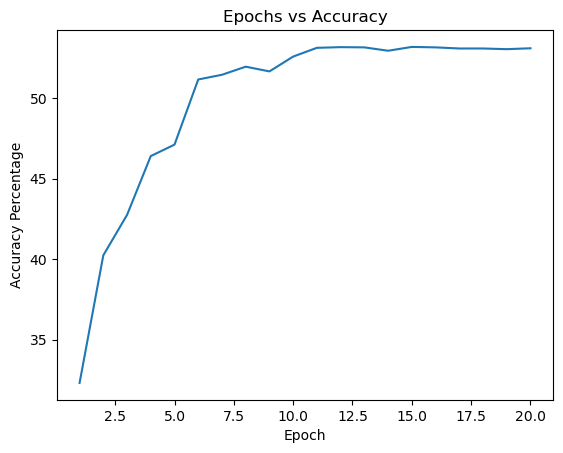

In [5]:
if __name__ == '__main__':
    for epoch in range(epoch_times): 
        print('Current epoch',epoch+1,'/',epoch_times, end=' ')
        Train()
        Test()
        scheduler.step()  # Update learning rate
        
plt.plot(epoch_arange, accuracy_result)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percentage')
plt.title('Epochs vs Accuracy')
plt.show()